*The Movies Dataset - eksploratorna analiza*
**Eva Lavrenčič, september 2021**

https://www.kaggle.com/rounakbanik/the-movies-dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from ast import literal_eval
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedShuffleSplit
sns.set_style('whitegrid')

In [2]:
# nalozi datoteke
# check current path
import pathlib
pathlib.Path().resolve()

# dfKeywords = pd.read_csv('keywords.csv', dtype='unicode')
dfMetadata = pd.read_csv('movies_metadata.csv', low_memory=False)
# dfCredits = pd.read_csv('credits.csv', dtype='unicode') # crew

# dfLinks = pd.read_csv('links.csv')
# dfLinksSmall = pd.read_csv('links_small.csv')
# dfRatings = pd.read_csv('ratings.csv')
# dfRatingsSmall = pd.read_csv('ratings_small.csv')

Podatki iz strani Kaggle (https://www.kaggle.com/rounakbanik/the-movies-dataset) zajemajo metapodatke za 45.000 filmov, izdanih pred julijem 2017. Podatki opisujejo igralce, snemalno ekipo, ključne besede, proračun filma, dobiček, posterje, datum izdaje, jezik, produkcijsko podjetje, državo, število TMDB glasov in povprečno oceno. Na voljo imamo tudi podatkovni set 26 milijonov ocen (1-5) 270.000 uporabnikov za vseh 45.000 filmov.

Namen naloge je pregledati podatke o filmih (osnovna eksploratorna analiza). Končni namen je izdelava napovednega modela predlaganja filma za novega uporabnika glede na uporabnikove želje.

# Pregled podatkov

## Podatkovni seti

### Metadata

In [3]:
dfMetadata = dfMetadata.dropna(thresh=(len(dfMetadata.columns) - 7)) # odstranimo vrstice, ki imajo večino vnosov NaN
# nekateri filmi imajo zamaknjene stolpce!!! z zgornjim korakom te večinoma odstranimo
# (lahko bi jih združili s kakšnim drugim datasatom glede na id)
# odstranimo podvojene vnose
dfMetadata=dfMetadata.drop_duplicates('id')


In [4]:
# filtriramo filme, ki so released
# izlocimo rumored, post production, in production in planned
dfMetadata = dfMetadata.loc[dfMetadata['status'] == 'Released']


In [5]:
# dfMetadata.head()

In [6]:
# dfMetadata.info()

In [7]:
# dfMetadata.dtypes.value_counts()

V podatkovnem setu Metadata je 24 atributov, od tega 4 številski in 20 kategoričnih.

#### Numerični atributi

In [8]:
# dfMetadata.describe()

Numerični atributi so:  

1) Revenue = prihodki. 38052 filmov (84 %) filmov ima Revenue enak 0. Ugotovi zakaj! -> možno kodiranje 0 kot manjkajoče vrednosti -> spremeni v NaN
- status = Released tudi pri filmih brez zabeleženih prihodkov //
- filmi brez Revenue so v povprečju nekoliko starejši, vendar to ni razlog
- Porazdelitev prihodkov filmov, ki imajo vpisan prihodek večji od 0, je močno asimetrična v desno. S čim je povezana? Rating? Budget? Drugi atributi?


2) Runtime (v minutah, 257 manjkajočih vrednosti)
- min = 0!, max = 1256 min (kateri film?), mediana 95 min, 1. kvartil 85 min, 3. kvartil 107 minut)
- filmi, ki imajo runtime = 0 -> preveri ali so released; označi vrednost kot NaN = napaka?
- uporabi filter: predlagaj filme, ki nimajo ekstremnih časov trajanj (v plus ali minus)

3) Vote average (brez NaN)
- povprečna ocena je 5.6, mediana 6.0
- minumum je 0 (brez ocene? preveri!), maksimum 10 (preveri, koliko ocen ima film)

4) Vote count (brez NaN)
- min = 0, max = 14075
- filmi z več ocenami = bolj popularni, bolj 'zanesljiva' ocena -> upoštevaj! (povprečno oceno filmov z malo ocenami označi kot NaN/uporabi uteži: povprečna ocena filmo z več ocenami ima večjo težo pri izbiri)


Dodatni numerični atributi (popravek):  
- Budget, ki ima nekaj nepravilnih vnosov -> poiščemo character values (.jpg) -> izbrišemo vrstice (nepravilen vnos)  
- Popularity  
- Starost (izračunana iz datuma izdaje)

In [9]:
# dfMetadata[dfMetadata.revenue == 0].shape[0] # 3760

In [10]:
# dfMetadata.budget
# list(set(dfMetadata.budget)) # unique values
# delete all rows with budget ending in .jpg -> wrong entries
# regular expressions
patternDel = "^.*jpg.*$" # vsebuje jpg
filter = dfMetadata['budget'].str.contains(patternDel)


In [11]:
dfMetadata = dfMetadata[~filter]

In [12]:
# pretvori budget v integer
# dfMetadata['budget'].astype(str).astype(int).hist()
dfMetadata['budget'] = pd.to_numeric(dfMetadata['budget'])


# dfMetadata[dfMetadata.budget == "0"].shape[0] # !!! spet ogromno nicel!!! (36573), podobno kot za revenue -> korelacija?

# dfMetadata[(dfMetadata.budget == "0") & (dfMetadata.revenue == 0)].shape[0] # !!! spet ogromno nicel!!! podobno kot za revenue ->
# 0 za revenue = tudi 0 za budget





In [13]:
dfMetadata['popularity'] = pd.to_numeric(dfMetadata['popularity'])
dfMetadata['popularity'].describe()

count    44985.000000
mean         2.938769
std          6.024704
min          0.000000
25%          0.390896
50%          1.135373
75%          3.728260
max        547.488298
Name: popularity, dtype: float64

In [14]:
# replace 0s with NaN ??
dfMetadata['revenue'] = dfMetadata['revenue'].replace(0, np.NaN)
dfMetadata['budget'] = dfMetadata['budget'].replace(0, np.NaN)
dfMetadata['runtime'] = dfMetadata['runtime'].replace(0, np.NaN)
dfMetadata['vote_average'] = dfMetadata['vote_average'].replace(0, np.NaN)


In [15]:
dfMetadata['release_year'] = pd.to_datetime(dfMetadata['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [16]:
# dfMetadata['release_year'].describe()

In [17]:
dfMetadata['release_year'] = dfMetadata['release_year'].apply(pd.to_numeric, errors='coerce')

In [18]:
# razdelimo v razrede glede na (približno) desetletja
dfMetadata = dfMetadata.assign(release_year_bins=pd.cut(dfMetadata['release_year'], 
                               bins=[1870, 1900, 1920, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020], 
                               labels=['1870-1900', '1900-1920', '1920-1940', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']))

array([[<AxesSubplot:title={'center':'budget'}>,
        <AxesSubplot:title={'center':'popularity'}>,
        <AxesSubplot:title={'center':'revenue'}>],
       [<AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'vote_average'}>,
        <AxesSubplot:title={'center':'vote_count'}>],
       [<AxesSubplot:title={'center':'release_year'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

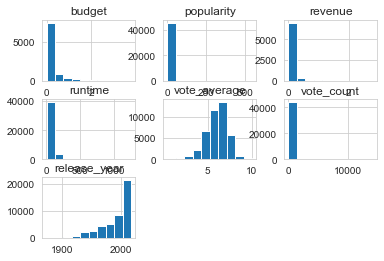

In [19]:
dfMetadata.hist()

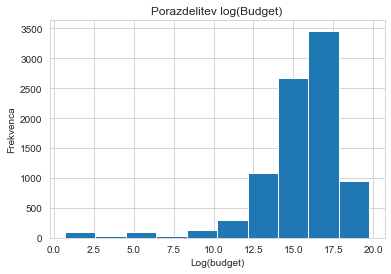

In [20]:
np.log1p(dfMetadata['budget']).hist()
plt.title("Porazdelitev log(Budget)")
plt.xlabel("Log(budget)")
plt.ylabel("Frekvenca")
plt.show()

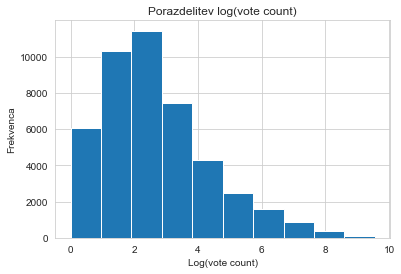

In [21]:
np.log1p(dfMetadata['vote_count']).hist()
plt.title("Porazdelitev log(vote count)")
plt.xlabel("Log(vote count)")
plt.ylabel("Frekvenca")
plt.show()

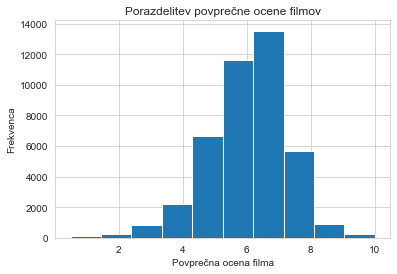

In [22]:
dfMetadata['vote_average'].hist()
plt.title("Porazdelitev povprečne ocene filmov")
plt.xlabel("Povprečna ocena filma")
plt.ylabel("Frekvenca")
plt.show()

Največ filmov je bilo ocenjenih z oceno 7. Povprečna ocena je 6.0, mediana 6.1. Porazdelitev je nekoliko asimetrična v levo.

<AxesSubplot:>

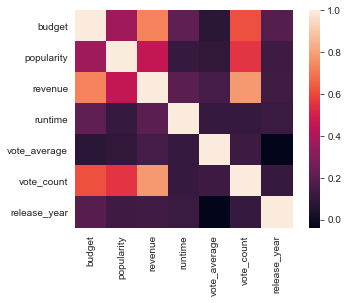

In [23]:
# korelacija med numeričnimi atributi
corr = dfMetadata.corr()
sns.heatmap(corr, vmax=1, square=True)

Revenue, Budget in Vote count so paroma srednje do močno pozitivno linearno povezani: filmi z več glasovi, so imeli tudi več dobička (bolj popularni). Drugi numerični atributi so zanemarljivo povezani. Noben par atributov ni povezan negativno.

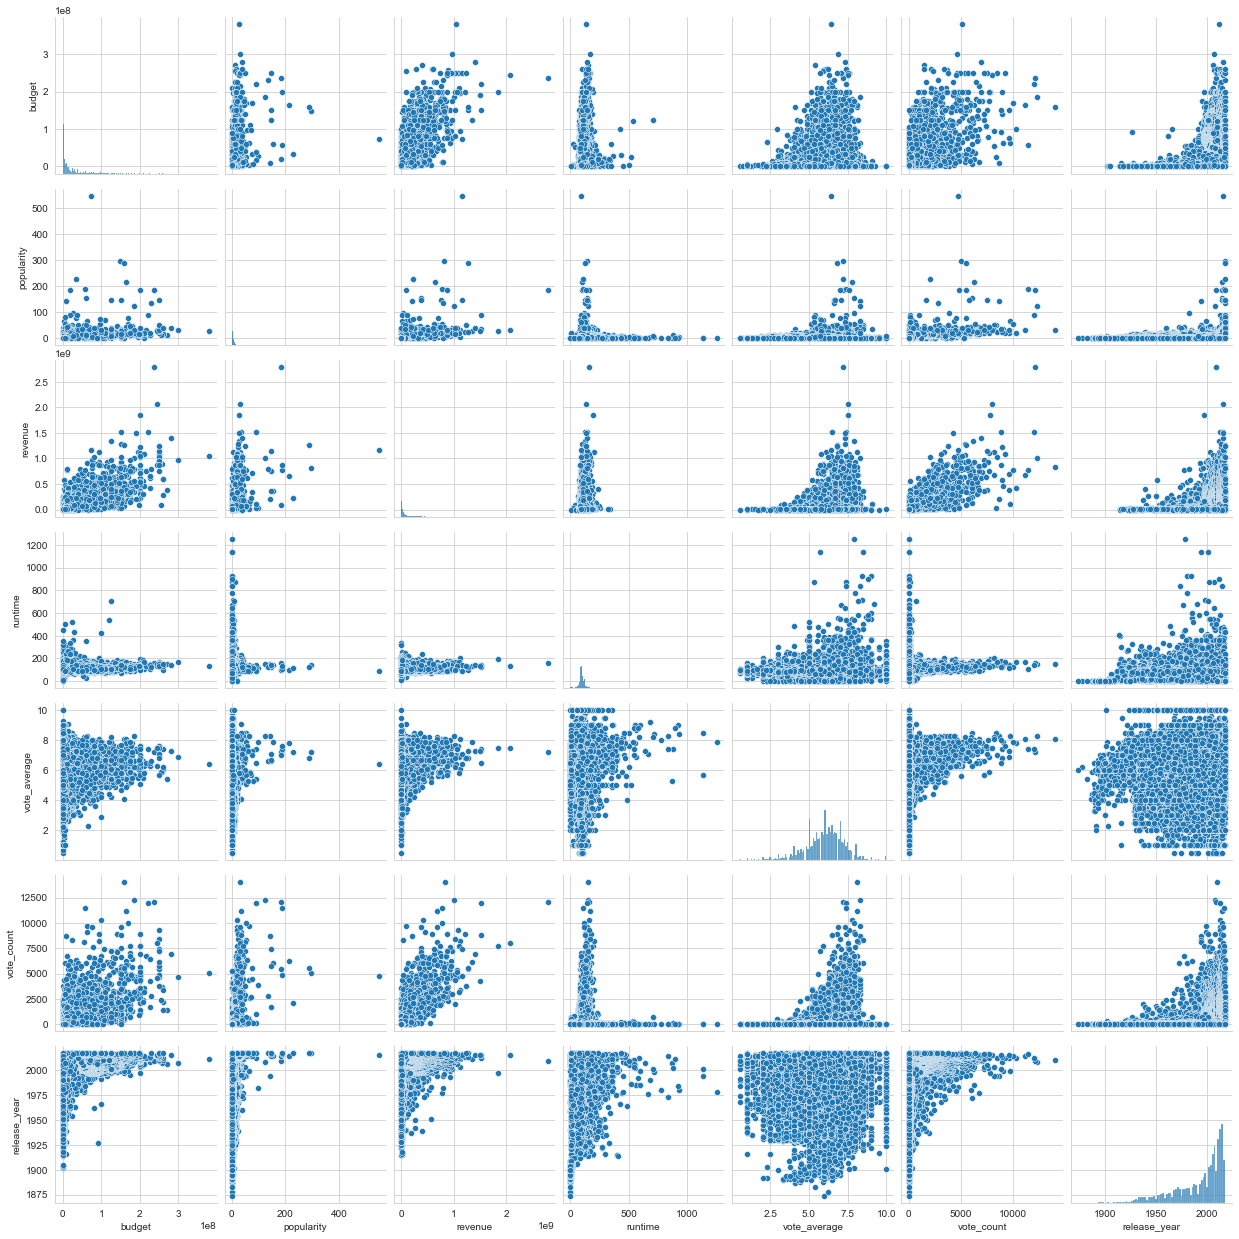

In [24]:
# stevilski atributi
num_attribs = list(dfMetadata.select_dtypes("float").columns) + list(dfMetadata.select_dtypes("int64").columns)

sns.pairplot(dfMetadata[num_attribs])

Filmi, daljši od 200 minut, imajo zelo malo ocen, prav tako filmi z zelo visoko/nizko povprečno oceno. Pazi na vodoravne/navpične črte! (0 ali blizu 0) oz. druge čudne vzorce. Preveri!

Text(0.5, 1.0, 'Proračun in prihodki skozi čas')

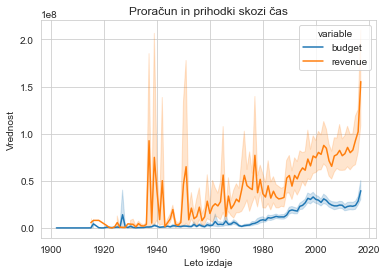

In [25]:
sns.lineplot(x='release_year', y='value', hue='variable', 
             data=pd.melt(dfMetadata[['release_year', 'budget', 'revenue']], ['release_year']))
plt.xlabel("Leto izdaje")
plt.ylabel("Vrednost")
plt.title("Proračun in prihodki skozi čas")

Proračun in prihodki skozi čas naraščajo. Če izbiramo filme glede na višji budget/revenue brez upoštevanja leta izdaje, bi favorizirali novejše filme.

Text(0, 0.5, 'Povprečna ocena')

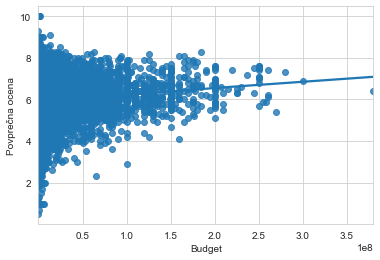

In [26]:
sns.regplot(x = dfMetadata['budget'], y = dfMetadata['vote_average'], lowess=True)
plt.xlabel('Budget')
plt.ylabel('Povprečna ocena')

Text(0, 0.5, 'Povprečna ocena')

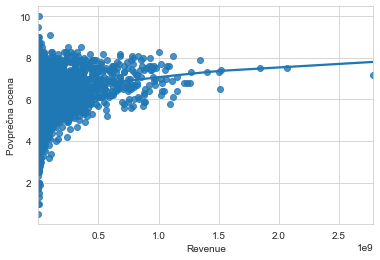

In [27]:
sns.regplot(x = dfMetadata['revenue'], y = dfMetadata['vote_average'], lowess=True)
plt.xlabel('Revenue')
plt.ylabel('Povprečna ocena')

In [28]:
# filmi z najvišjim budgetom
dfMetadata[['original_title', 'budget']].sort_values('budget',ascending = False).head()

,original_title,budget
17124,Pirates of the Caribbean: On Stranger Tides,380000000.0
11827,Pirates of the Caribbean: At World's End,300000000.0
26558,Avengers: Age of Ultron,280000000.0
11067,Superman Returns,270000000.0
18685,John Carter,260000000.0


In [29]:
# filmi z najvišjimi prihodki
dfMetadata[['original_title', 'revenue']].sort_values('revenue',ascending = False).head()

,original_title,revenue
14551,Avatar,2.787965e+09
26555,Star Wars: The Force Awakens,2.068224e+09
1639,Titanic,1.845034e+09
17818,The Avengers,1.519558e+09
25084,Jurassic World,1.513529e+09


#### Kategorični atributi

In [30]:
cat_attribs = list(dfMetadata.select_dtypes("object").columns)
# cat_attribs
cat_attribs_sublist = ['adult', 'original_language', 'release_year_bins']

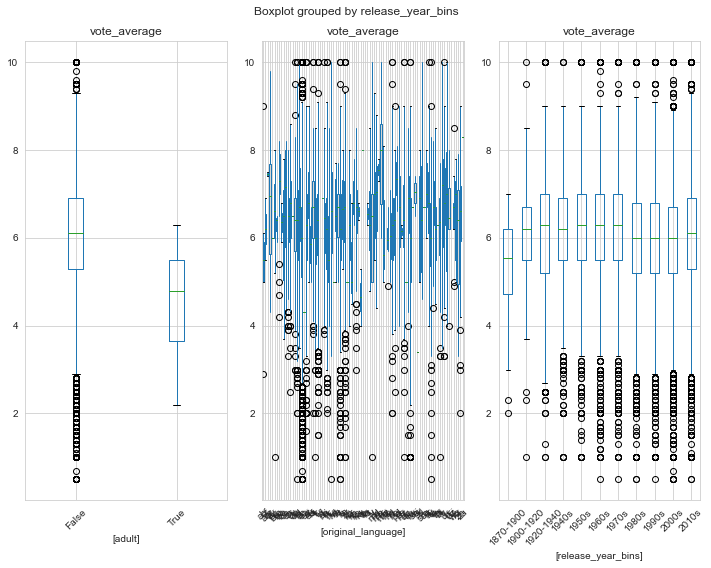

In [31]:
fig = plt.figure(figsize=(10,8))

for column, ind in zip(dfMetadata[cat_attribs_sublist].iloc[:, : 3], range(1,4)):
    ax = fig.add_subplot(1,3,ind)
    dfMetadata.boxplot("vote_average", by=[column], ax=ax, rot=45)
    
    
plt.tight_layout()
plt.show()

Ne opazimo velikih razlik v povprečni oceni filmov glede na desetletje izdaje.

In [32]:
# dfMetadata.select_dtypes("object")

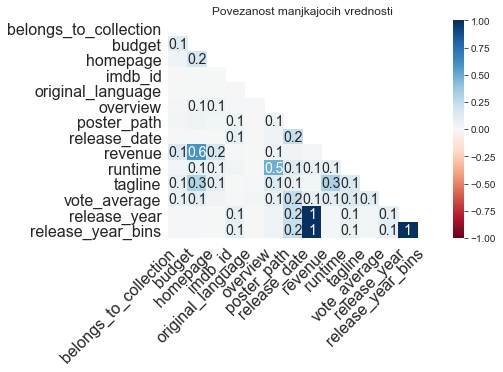

In [33]:
ax = plt.axes()
msno.heatmap(dfMetadata, ax = ax)
ax.set_title('Povezanost manjkajocih vrednosti')
plt.show()


In [34]:
dfMetadata['adult'].value_counts()

False    44977
True         8
Name: adult, dtype: int64

<AxesSubplot:xlabel='adult', ylabel='count'>

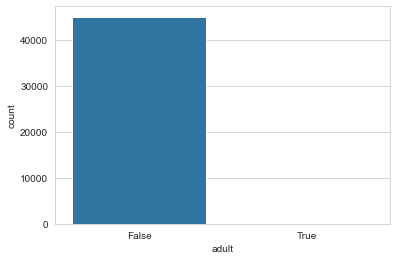

In [35]:
sns.countplot(x='adult', data=dfMetadata)

8 filmov za odrasle -> posebna kategorija. Rekodiraj v 0/1 oz. filtriraj.

Text(0.5, 1.0, 'Število filmov glede na desetletje izdaje')

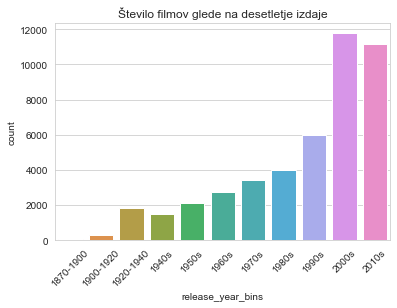

In [36]:
sns.countplot(x='release_year_bins', data=dfMetadata)
plt.xticks(rotation=45)
plt.title('Število filmov glede na desetletje izdaje')

Število filmov v našem podatkovnem setu narašča z obdobjem izdaje.

In [37]:
# dictionaries: genres, collection, production_companies, production_countries, spoken_languages (imamo tudi original_language)
# genres: spremeni v list
# shrani prvi žanr
dfMetadata['genres_extract_first'] = dfMetadata.loc[dfMetadata['genres'].notna(), 'genres'].str.split("'name': ").str[1].str.split("'").str[1]

# spoken_languages -> spremeni v list
dfMetadata['spoken_languages_extract'] = dfMetadata['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x]if isinstance(x,list) else [])

# shrani production company (1) + production countries
dfMetadata['prodaction_companies_first'] = dfMetadata.loc[dfMetadata['production_companies'].notna(), 'genres'].str.split("'name': ").str[1].str.split("'").str[1]
dfMetadata['production_countries_extract'] = dfMetadata['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x]if isinstance(x,list) else [])


Text(0.5, 0, 'Žanr')

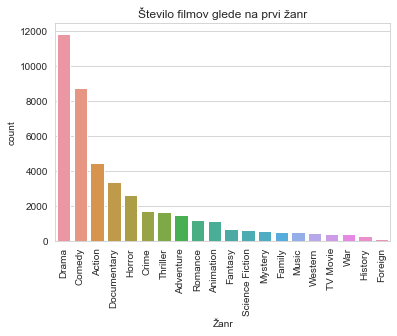

In [38]:
sns.countplot(x='genres_extract_first', data=dfMetadata, order = dfMetadata['genres_extract_first'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Število filmov glede na prvi žanr')
plt.xlabel("Žanr")


Najbolj pogosti žanri so drama, komedija, akcija, dokumentarni film in grozljivka.

Text(0.5, 0, 'Originalni jezik')

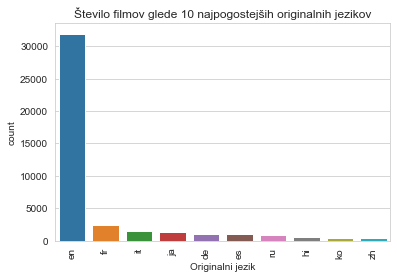

In [39]:
sns.countplot(x='original_language', data=dfMetadata, order =dfMetadata.original_language.value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.title('Število filmov glede 10 najpogostejših originalnih jezikov')
plt.xlabel("Originalni jezik")

Večina filmov v naših podatkih je posnetih v angleškem jeziku.

In [40]:
# dfMetadata['belongs_to_collection']
#NaN = 0, ostalo = 1 (rekodiraj: oznaci filme, ki so del zbirke)

***Credits***

In [41]:
#dfCredits.head

- cast: character info, crew, director (id, ime, spol (1 = ženska, 2 = moški, 3 = drugo/ni poznano))  
- id filma: združi podatke (merge) z metadata in uredi podatke  
- preveri, ali so id-ji enaki, ali imamo podatke za vse filme

***Keywords***  
- združi z Metadata  
- poglej, kateri filmi imajo podobne ključne besede -> NLP ??? cosine similarity ? word2vec ?

In [42]:
# dfKeywords.info()
# dfKeywords.head

***Links***  
- zdruzi z Metadata  
- IMDB in TMDB id -> poveži z obema bazama podatkov -> primerjaj oceni  

In [43]:
# dfLinks.info()
# dfLinks.head

In [44]:
# dfLinksSmall.info()

***Ratings***  
- povprečni rating / variabilnost (želimo priporočiti film, ki ga je večina ljudi dobro ocenila: visoka povprečna ocena in majhna variabilnost ocen)  
- spreminjanje ocen skozi čas

In [45]:
# dfRatings.head

In [46]:
# dfRatingsSmall.info()
# dfRatingsSmall.head

## Oblikovanje novih atributov
- utežena ocena (povprečna ocena) -> upoštevamo povprečno oceno, število glasov, priljubljensot, IMDB in TMDB oceno
- del zbirke: 0 / 1
- Žanr -> one hot encoder -> oblikuj neme spremenljivke 0 / 1
- Original language -> Angleški / tuj film
- Koprodukcija (posnet v več kot eni državi)
- najpogostejši žanr / jezik
- desetletje izdaje filma / starost filma
- NLP analiza ključnih besed

...



# POVZETEK UREJANJA METAPODATKOV
- odstranimo vrstice, ki imajo večino vnosov NaN
- odstranimo podvojene vnose (id)
- filter: status = released
- izbrišemo vrstice, kjer budget ni številki -> napačen vnos (zamaknjeni stolpci, večina stolpcev manjka)
- pretvorimo budget v popularity v številski tip
- filtriramo filme, ki imajo vsaj x ocen; podobno filtriramo filme, ki nimajo odstopajočih časov trajanja
- spremenimo 0 (pri budget, revenue, popularity, vote_average) v NaN
- izpišemo leto izida in izračunamo starost filma
- leto izida združimo v kategorije
- odstranimo filme za odrasle
- genres, spoken languages, production country, production country -> izpišemo vrednosti





# PRIPOROČANJE FILMOV (ALGORITEM)

Gledalcu želimo ponuditi film, ki je podoben njegovim prejšnjim izbiram. Potrebujemo mero, ki bo ocenila podobnost med filmi. Med pomembne atribute bi lahko sodili žanr filma, ključne besede, jezik, obdobje izdaje, režiser, igralci ... Ker gre za opisne atribute bi lahko uporabili enega od algoritmov NLP (cosine similarity ??? / matrika sorodnosti / graf povezanosti). Na podlagi izračunanih podobnosti bi izbrali skupino podobnih filmov (+ clustering), med katerimi bi nato predlagali filme z visoko uteženo oceno (sestavljena iz povprečne ocene, števila ocen, leta izdaje, proračuna, priljubljenosti itd. - tu bi torej lahko uporabili številske atribute)). 